# Predicting Book Review as positive or negative based on written Amazon Book Reviews 

NLP with Deep Learning

Kane Egan

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/KaneEgan/cs39aa_project/blob/main/AmazonBookReviewsModel.ipynb)

In this model we will look at how a prediction of Amazon book reviews written statements being positive or negative.
Below we will import the required packages for this model.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk # text tokenization
import tensorflow as tf
import torch
nltk.download('wordnet') 
nltk.download('omw-1.4') 
from nltk.tokenize import word_tokenize #text tokenization
from nltk.stem import WordNetLemmatizer
from tensorflow import keras

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


We will add the data subset to work with from the Exploratory Data Analysis.

In [2]:
df = pd.read_csv("../input/reviews-subset/reviews_subset.csv")
df.shape

(10000, 10)

Here are the first 5 entries to show the type of data available. 

In [3]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B0006AQ616,Walt Whitman,NaN,A244RGQNVMCDIK,Simon of the Pulpitzer Awards,3/3,5.0,1216857600,Great Reproduction,"I've been doing some research on Whitman, and ..."
1,B000GSDG8E,"Rich Dad, Poor Dad",NaN,A2OS1H34LALKGD,"mobius ""mobiuspowershred""",4/10,2.0,962409600,Where's the BEEEFFFF?,Kinda like all the hype with the new Star Wars...
2,B000QKT4LA,Path of the Jaguar,NaN,A3PM6M7X1GH200,accisse,2/2,3.0,1342396800,Mystery and romance,A tidy little light mystery. It is not a thril...
3,B000HEGHT2,Speaker for the Dead,NaN,ALD7XTUFKNL7D,T. Peck,0/0,5.0,1344297600,"A great vacation read, Orson Scott Card Speake...","The second book in the series, the characters ..."
4,0873384458,Showplace of America: Cleveland's Euclid Avenu...,47.0,A2TLFM93VB73B4,Blake7134,2/2,5.0,1314835200,Great Book!,I've been interested in Cleveland history for ...


We will preprocess our data by removing empty entries in review/text; and columns of Price, User_id, profileName, review/time, and review/summary. The columns removed are not used in this model and reduce screen clutter.

In [4]:
df = df.drop(columns={'Price', 'User_id', 'profileName', 'review/time','review/summary'})
df['review/text'].dropna(inplace=True)
df.head()

,Id,Title,review/helpfulness,review/score,review/text
0,B0006AQ616,Walt Whitman,3/3,5.0,"I've been doing some research on Whitman, and ..."
1,B000GSDG8E,"Rich Dad, Poor Dad",4/10,2.0,Kinda like all the hype with the new Star Wars...
2,B000QKT4LA,Path of the Jaguar,2/2,3.0,A tidy little light mystery. It is not a thril...
3,B000HEGHT2,Speaker for the Dead,0/0,5.0,"The second book in the series, the characters ..."
4,0873384458,Showplace of America: Cleveland's Euclid Avenu...,2/2,5.0,I've been interested in Cleveland history for ...


Now we will tokenize the review/text and assign new the tokens to a new column.

In [5]:
df['review/text'] = df['review/text'].astype(str).str.lower()
df['text_tokens'] = df['review/text'].apply(nltk.word_tokenize)
df.head()

,Id,Title,review/helpfulness,review/score,review/text,text_tokens
0,B0006AQ616,Walt Whitman,3/3,5.0,"i've been doing some research on whitman, and ...","[i, 've, been, doing, some, research, on, whit..."
1,B000GSDG8E,"Rich Dad, Poor Dad",4/10,2.0,kinda like all the hype with the new star wars...,"[kinda, like, all, the, hype, with, the, new, ..."
2,B000QKT4LA,Path of the Jaguar,2/2,3.0,a tidy little light mystery. it is not a thril...,"[a, tidy, little, light, mystery, ., it, is, n..."
3,B000HEGHT2,Speaker for the Dead,0/0,5.0,"the second book in the series, the characters ...","[the, second, book, in, the, series, ,, the, c..."
4,0873384458,Showplace of America: Cleveland's Euclid Avenu...,2/2,5.0,i've been interested in cleveland history for ...,"[i, 've, been, interested, in, cleveland, hist..."


To improve the model let's remove stop words and punctuation symbols.

In [6]:
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
chars2remove = set(['.','!','/', '?','(',')', ',', ';'])
df['text_tokens'] = df['text_tokens'].apply(lambda x: [w for w in x if w not in stops])
df['text_tokens'] = df['text_tokens'].apply(lambda x: [w for w in x if w not in chars2remove])
df.head()

,Id,Title,review/helpfulness,review/score,review/text,text_tokens
0,B0006AQ616,Walt Whitman,3/3,5.0,"i've been doing some research on whitman, and ...","['ve, research, whitman, one, books, originall..."
1,B000GSDG8E,"Rich Dad, Poor Dad",4/10,2.0,kinda like all the hype with the new star wars...,"[kinda, like, hype, new, star, wars, movie, ....."
2,B000QKT4LA,Path of the Jaguar,2/2,3.0,a tidy little light mystery. it is not a thril...,"[tidy, little, light, mystery, thrilling, page..."
3,B000HEGHT2,Speaker for the Dead,0/0,5.0,"the second book in the series, the characters ...","[second, book, series, characters, continue, e..."
4,0873384458,Showplace of America: Cleveland's Euclid Avenu...,2/2,5.0,i've been interested in cleveland history for ...,"['ve, interested, cleveland, history, quite, l..."


We will use a lemmatizer to get the root words used in the reviews.

In [7]:
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['text_tokens'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
df.head()

,Id,Title,review/helpfulness,review/score,review/text,text_tokens,tokens
0,B0006AQ616,Walt Whitman,3/3,5.0,"i've been doing some research on whitman, and ...","['ve, research, whitman, one, books, originall...","['ve, research, whitman, one, book, originally..."
1,B000GSDG8E,"Rich Dad, Poor Dad",4/10,2.0,kinda like all the hype with the new star wars...,"[kinda, like, hype, new, star, wars, movie, .....","[kinda, like, hype, new, star, war, movie, ......"
2,B000QKT4LA,Path of the Jaguar,2/2,3.0,a tidy little light mystery. it is not a thril...,"[tidy, little, light, mystery, thrilling, page...","[tidy, little, light, mystery, thrill, page-tu..."
3,B000HEGHT2,Speaker for the Dead,0/0,5.0,"the second book in the series, the characters ...","[second, book, series, characters, continue, e...","[second, book, series, character, continue, ex..."
4,0873384458,Showplace of America: Cleveland's Euclid Avenu...,2/2,5.0,i've been interested in cleveland history for ...,"['ve, interested, cleveland, history, quite, l...","['ve, interest, cleveland, history, quite, lon..."


Next, we assign the review/scores to positive, negative, and neutral. And rename review/score to review_rating for ease of format.

In [8]:
df.rename(columns={'review/score': 'review_rating'}, inplace=True)
df.head()

,Id,Title,review/helpfulness,review_rating,review/text,text_tokens,tokens
0,B0006AQ616,Walt Whitman,3/3,5.0,"i've been doing some research on whitman, and ...","['ve, research, whitman, one, books, originall...","['ve, research, whitman, one, book, originally..."
1,B000GSDG8E,"Rich Dad, Poor Dad",4/10,2.0,kinda like all the hype with the new star wars...,"[kinda, like, hype, new, star, wars, movie, .....","[kinda, like, hype, new, star, war, movie, ......"
2,B000QKT4LA,Path of the Jaguar,2/2,3.0,a tidy little light mystery. it is not a thril...,"[tidy, little, light, mystery, thrilling, page...","[tidy, little, light, mystery, thrill, page-tu..."
3,B000HEGHT2,Speaker for the Dead,0/0,5.0,"the second book in the series, the characters ...","[second, book, series, characters, continue, e...","[second, book, series, character, continue, ex..."
4,0873384458,Showplace of America: Cleveland's Euclid Avenu...,2/2,5.0,i've been interested in cleveland history for ...,"['ve, interested, cleveland, history, quite, l...","['ve, interest, cleveland, history, quite, lon..."


In [9]:
def convert(row):
    if row.review_rating > 3:
        return 'positive'
    elif row.review_rating < 3:
        return 'negative'
    elif row.review_rating == 3:
        return 'neutral'
    

df['rating'] = df.apply(convert, axis=1)

df.head()

,Id,Title,review/helpfulness,review_rating,review/text,text_tokens,tokens,rating
0,B0006AQ616,Walt Whitman,3/3,5.0,"i've been doing some research on whitman, and ...","['ve, research, whitman, one, books, originall...","['ve, research, whitman, one, book, originally...",positive
1,B000GSDG8E,"Rich Dad, Poor Dad",4/10,2.0,kinda like all the hype with the new star wars...,"[kinda, like, hype, new, star, wars, movie, .....","[kinda, like, hype, new, star, war, movie, ......",negative
2,B000QKT4LA,Path of the Jaguar,2/2,3.0,a tidy little light mystery. it is not a thril...,"[tidy, little, light, mystery, thrilling, page...","[tidy, little, light, mystery, thrill, page-tu...",neutral
3,B000HEGHT2,Speaker for the Dead,0/0,5.0,"the second book in the series, the characters ...","[second, book, series, characters, continue, e...","[second, book, series, character, continue, ex...",positive
4,0873384458,Showplace of America: Cleveland's Euclid Avenu...,2/2,5.0,i've been interested in cleveland history for ...,"['ve, interested, cleveland, history, quite, l...","['ve, interest, cleveland, history, quite, lon...",positive


Now we will split the dataset of 10,000 into a training dataset of 6,000 and validation dataset of 4,000.

In [10]:
import random
random.seed(89)

df_full = df.copy()
assert df_full.shape[0] == 10000

indices = list(range(df_full.shape[0]))

random.shuffle(indices)

train_indices = indices[:6000]
test_indices = indices[6000:]

# df will be the in-sample training dataset
df = df_full.iloc[train_indices,:].copy()
print(f"df.shape: {df.shape}")

# df_test will be the out-of-sample validation dataset
df_test = df_full.iloc[test_indices,:].copy()
print(f"df_test.shape: {df_test.shape}")
df_test.head()

df.shape: (6000, 8)
df_test.shape: (4000, 8)


,Id,Title,review/helpfulness,review_rating,review/text,text_tokens,tokens,rating
9053,B000Q032UY,The Hobbit or There and Back Again,0/2,3.0,the story is not that interesting if you have ...,"[story, interesting, watched, lord, ring, seri...","[story, interest, watch, lord, ring, series, p...",neutral
351,B0006IU3ZS,Unfit for Command: Swift Boat Veterans Speak O...,7/11,4.0,i was sorry to see that amazon.com suspends th...,"[sorry, see, amazon.com, suspends, rules, comm...","[sorry, see, amazon.com, suspend, rule, commen...",positive
6855,0940666162,Long John Dunn of Taos: From Texas Outlaw to N...,0/0,5.0,wow...can't believe i had never heard of john ...,"[wow, ..., ca, n't, believe, never, heard, joh...","[wow, ..., ca, n't, believe, never, hear, john...",positive
210,1581804091,Realistic Pet Portraits in Colored Pencil,4/4,5.0,"i bought this book with several others, and i ...","[bought, book, several, others, ca, n't, put, ...","[buy, book, several, others, ca, n't, put, tru...",positive
4270,0970417608,Genius Frequency,1/1,5.0,i was intuitively lead to purchase this book. ...,"[intuitively, lead, purchase, book, must, read...","[intuitively, lead, purchase, book, must, read...",positive


Subset the data into positive, negative, and neutral. 

In [11]:
# subset the data by positive, negative, and neutral
df_pos = df[df['rating'] == 'positive']
df_neg = df[df['rating'] == 'negative']
df_neu = df[df['rating'] == 'neutral']

def create_vocab_list(tokens_column):
    vocab = dict()
    for review_tokens in tokens_column:
        for token in review_tokens:
            if token not in vocab:
                vocab[token] = 1
            else:
                vocab[token] += 1
    return vocab

vocab_all = dict(sorted(create_vocab_list(df['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_pos = dict(sorted(create_vocab_list(df_pos['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neg = dict(sorted(create_vocab_list(df_neg['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neu = dict(sorted(create_vocab_list(df_neu['tokens']).items(), key=lambda item: item[1], reverse=True))
print(f"number of unique tokens overall: {len(vocab_all)}, pos tokens: {len(vocab_pos)}, neg: {len(vocab_neg)}, neu: {len(vocab_neu)}")

number of unique tokens overall: 40569, pos tokens: 34958, neg: 10230, neu: 9920


In [12]:
list(vocab_all.items())[:20]

[('book', 13185),
 ("'s", 7856),
 ('read', 6125),
 ('one', 3627),
 ("n't", 3577),
 ('``', 3358),
 ("''", 3132),
 ('&', 3092),
 ('like', 2632),
 ('quot', 2565),
 ('story', 2385),
 ('make', 2325),
 ('time', 2319),
 ('get', 2251),
 ('write', 2220),
 ('would', 2191),
 ('character', 1976),
 ('find', 1947),
 ('think', 1891),
 ('love', 1849)]

Create a object to hold dictionary of the vocabulary for positive, negative, and neutral classes. 

In [13]:
classifier_tokens = {"positive": list(vocab_pos.keys())[:], "negative": list(vocab_neg.keys())[:], "neutral": list(vocab_neu.keys())[:]}

# a sample review to classify
review2classify_i = 42
review2classify = df.iloc[review2classify_i,:]['tokens']
print(f"example of review to classify: \n  sentiment = {df.iloc[review2classify_i,7]} \n  review = {df.iloc[review2classify_i,4]}")

pos = 0
neg = 0
neu = 0
for tok in review2classify:
    if tok in classifier_tokens['positive']:
        pos += 1
    elif tok in classifier_tokens['negative']:
        neg += 1
    elif tok in classifier_tokens['neutral']:
        neu += 1

print(f"\n vocab counts: pos = {pos},  neg = {neg},  neu = {neu}")

example of review to classify: 
  sentiment = positive 
  review = this is going sound like this is an exaggeration but i assure you it is not. every man and woman should be required to read this book and pass an exam prior to receiving a marriage license. we do it for a driver's license yet we allow people to crash their marriages by the thousands each year. this is an excellent book.

 vocab counts: pos = 29,  neg = 0,  neu = 0


We convert the tkens to strings to enable the use of the sklearn vectorizer.

In [14]:
df['textclean'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

,Id,Title,review/helpfulness,review_rating,review/text,text_tokens,tokens,rating,textclean
504,B0006ARCFK,"The grapes of wrath, (The living library)",1/1,5.0,so often i find myself chasing the best seller...,"[often, find, chasing, best, sellers, looking,...","[often, find, chase, best, sellers, look, book...",positive,often find chase best sellers look book read r...
1598,0439317452,How To Draw Manga,0/0,2.0,"this was my frist manga book, and it taught me...","[frist, manga, book, taught, lot, bad, habbits...","[frist, manga, book, teach, lot, bad, habbits,...",negative,frist manga book teach lot bad habbits young a...
3683,0385506600,Higher: A Historic Race to the Sky and the Mak...,4/4,4.0,the 1920's was all about reaching new heights ...,"[1920, 's, reaching, new, heights, america, -,...","[1920, 's, reach, new, heights, america, -, ro...",positive,1920 's reach new heights america - roar 20 's...
4541,B00089PPA8,Merry adventures of Robin Hood: Of great renow...,8/9,5.0,"seldom does one come across such a fresh, deli...","[seldom, one, come, across, fresh, delightful,...","[seldom, one, come, across, fresh, delightful,...",positive,seldom one come across fresh delightful storyt...
8112,0688015395,Dancers' Body Book,36/48,1.0,do not buy this book. this book promotes eatin...,"[buy, book, book, promotes, eating, disorders,...","[buy, book, book, promote, eat, disorder, plai...",negative,buy book book promote eat disorder plain simpl...


Conversion of each review into a vector using term-frequency  inverse-document-frequency vectorizer TfidVectorizer.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(df['textclean']).toarray()

print(f"X_train.shape = {X_train.shape}")

X_train.shape = (6000, 32620)


Convert rating labels to numpy data type.

In [16]:
y_train = df.rating.to_numpy()
y_train[:10]

array(['positive', 'negative', 'positive', 'positive', 'negative',
       'positive', 'positive', 'positive', 'positive', 'neutral'],
      dtype=object)

Train the data using Random Forrest.

accuracy (on X_train): 1.0000


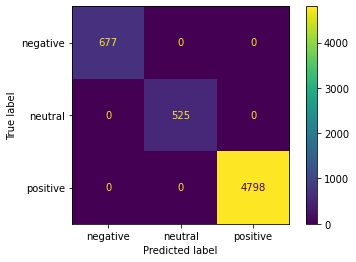

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
model = RandomForestClassifier(n_estimators=200)
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_train

disp = ConfusionMatrixDisplay(confusion_matrix(df['rating'], predictions_train), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(df['rating'], predictions_train):.4f}")

Perform same data type conversion and vectorization for test dataset. Then train test dataset.

In [18]:
df_test['textclean'] = df_test['tokens'].apply(lambda x: ' '.join(x))
X_test = tfidf_vectorizer.transform(df_test['textclean']).toarray()
X_test.shape

(4000, 32620)

accuracy (on X_test): 0.8047


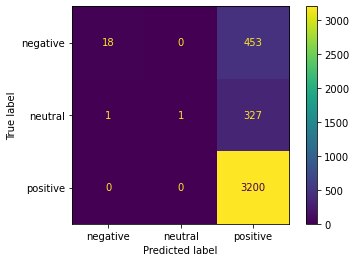

In [19]:
predictions_test = model.predict(X_test)
disp = ConfusionMatrixDisplay(confusion_matrix(df_test['rating'], predictions_test), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_test): {accuracy_score(df_test['rating'], predictions_test):.4f}")

Model performance was 80.47%. Not that great. Let's see what happens when we tune the hyperparameters.

In [26]:
from sklearn.metrics import log_loss

# A function to create and fit a RF with a specific number of trees
def fitRFModel(hyperparam_value):
    rf_model = RandomForestClassifier(n_estimators=hyperparam_value, random_state=4)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_test)
    y_val_pred = rf_model.predict(X_test)
    train_loss = log_loss(df['rating'], y_train_pred_prob, labels=['negative', 'neutral', 'positive']) 
    train_acc = accuracy_score(df['rating'], y_train_pred)
    val_loss = log_loss(df_test['rating'], y_val_pred_prob, labels=['negative', 'neutral', 'positive'])
    val_acc = accuracy_score(df_test['rating'], y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

# Possible values of min_samples_split are 10 to 70 (by 5)
hyp_param_vals = list(range(5,80,5))

metrics = []
for hp in hyp_param_vals:
    metrics.append(fitRFModel(hp))

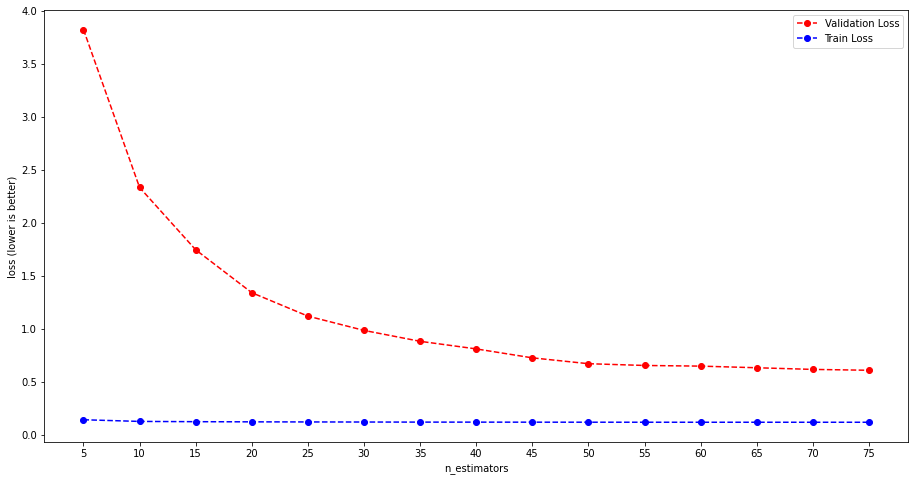

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0, 0, 1, 1]) #.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validattion loss
ax.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
ax.legend(["Validation Loss", "Train Loss"], loc=1)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel="n_estimators", ylabel="loss (lower is better)")
plt.show()

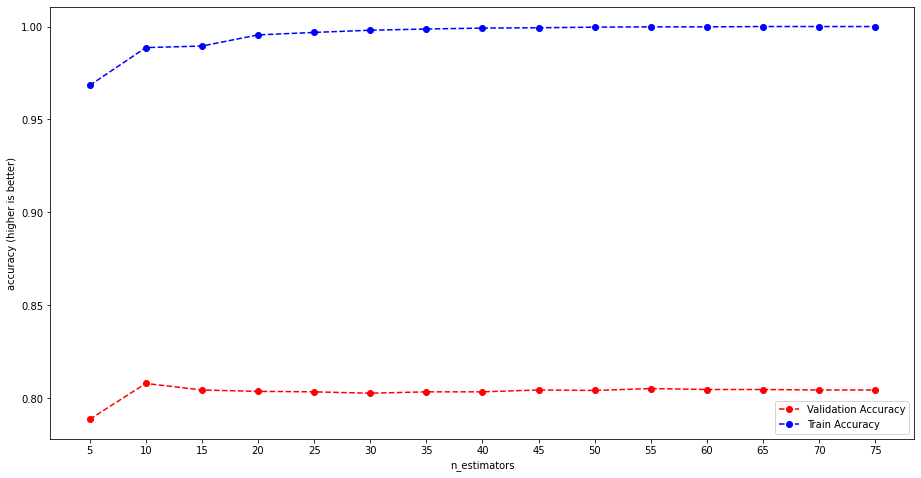

In [28]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0, 0, 1, 1]) #.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validattion accuracy
ax.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
ax.legend(["Validation Accuracy", "Train Accuracy"], loc=4)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel="n_estimators", ylabel="accuracy (higher is better)")
plt.show()

Tuning model to new range.

In [31]:
hyp_param_vals = list(range(5,15,1))

metrics = []
for hp in hyp_param_vals:
    metrics.append(fitRFModel(hp))

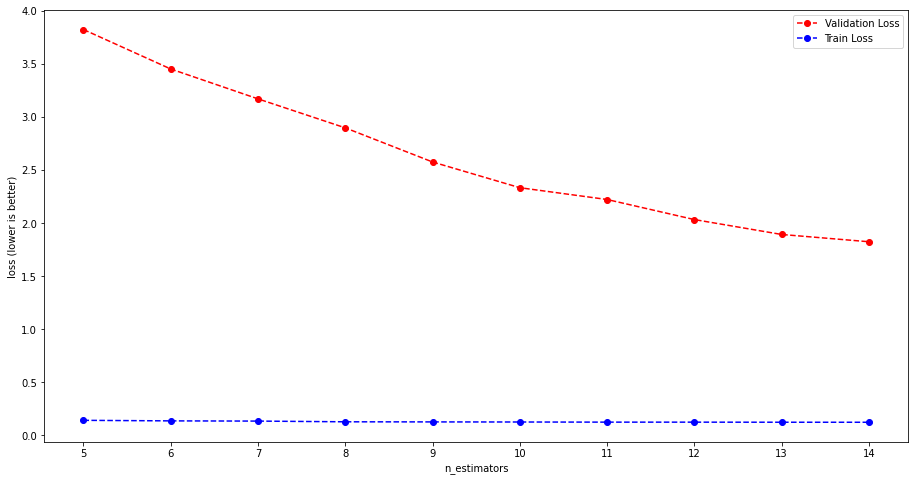

In [32]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0, 0, 1, 1]) #.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validattion loss
ax.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
ax.legend(["Validation Loss", "Train Loss"], loc=1)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel="n_estimators", ylabel="loss (lower is better)")
plt.show()

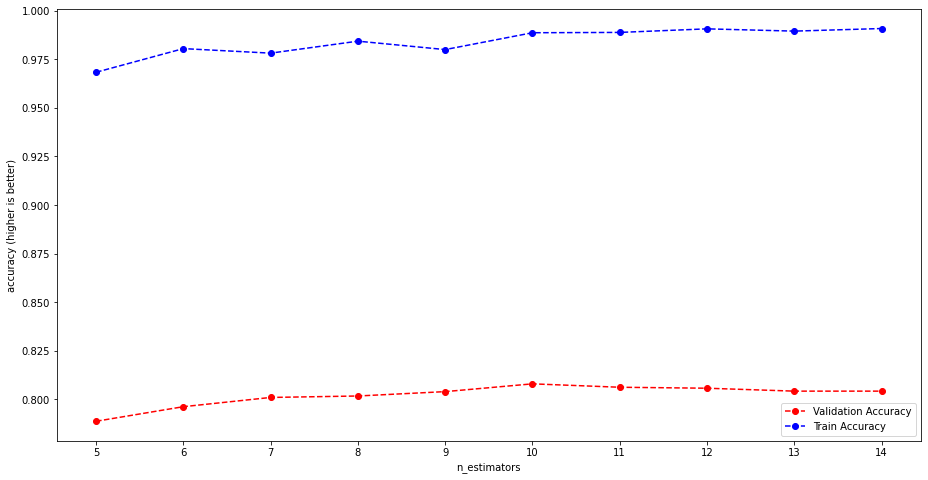

In [33]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0, 0, 1, 1]) #.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validattion accuracy
ax.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
ax.legend(["Validation Accuracy", "Train Accuracy"], loc=4)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel="n_estimators", ylabel="accuracy (higher is better)")
plt.show()

The highest validation accuracy is at n_estimators of 10.

accuracy (on X_train): 0.9888


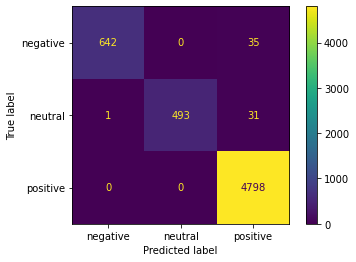

In [34]:
model = RandomForestClassifier(n_estimators=10)
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_train

disp = ConfusionMatrixDisplay(confusion_matrix(df['rating'], predictions_train), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(df['rating'], predictions_train):.4f}")

accuracy (on X_test): 0.8065


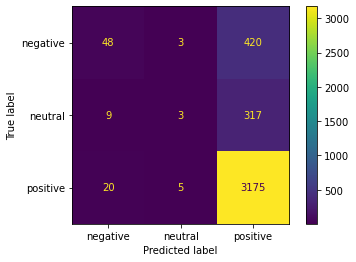

In [35]:
predictions_test = model.predict(X_test)
disp = ConfusionMatrixDisplay(confusion_matrix(df_test['rating'], predictions_test), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_test): {accuracy_score(df_test['rating'], predictions_test):.4f}")